In [2]:
#from __future__ import absolute_import, division, print_function
from itertools import islice
import argparse
import json
import os
import random
import pickle
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

import wandb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn import MSELoss
VISUAL_DIM = 768
TEXT_DIM = 512
CAPTION_DIM = 100
USER_DIM = 17
USER_EMB = 60093
CAT_EMB = 11
SUBCAT_EMB = 77
CONCEPT_EMB = 669
SEQ_LEN = 8

/home/ming0531/miniconda3/envs/drct/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def set_random_seed(seed: int):
    """
    Helper function to seed experiment for reproducibility.
    If -1 is provided as seed, experiment uses random seed from 0~9999

    Args:
        seed (int): integer to be used as seed, use -1 to randomly seed experiment
    """

    print("Seed: {}".format(seed))

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def test_epoch(model: nn.Module, test_dataloader: DataLoader):
    model.eval()
    prediction = []
    labels = []
    dev_loss = 0
    nb_dev_examples, nb_dev_steps = 0, 0
    attn_w = 0
    idx = 0
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            batch = tuple(t.to('cuda') for t in batch)
            caption, visual, text, category, user, label = batch
            #print('batch: visual, text, category, user, label', visual, text, category, user, label)
            outputs, attn = model.test(
                caption,
                visual,
                text,
                category,
                user
            )
            #print('outputs, label',outputs, label)
            label = label.squeeze(1)
            logits = outputs
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), label.view(-1))

            #print(loss,logits,label)
            logits = logits.detach().cpu().numpy()
            label = label.detach().cpu().numpy()

            logits = np.squeeze(logits).tolist()
            label = np.squeeze(label).tolist()
            #print(logits,label)
            prediction.extend([logits])
            labels.extend([label])
            #print(dev_loss)
            dev_loss += loss.item()
            nb_dev_steps += 1
            if idx == 0:
                attn_w = attn.cpu().numpy()
            idx += 1
        prediction = np.array(prediction)
        labels = np.array(labels)
        #print('prediction, labels, dev_loss, attn_w',prediction, labels, dev_loss, attn_w)
    return prediction, labels, dev_loss, attn_w
    #return prediction, labels, dev_loss / nb_dev_steps, attn_w


def test_score_model(model: nn.Module, test_dataloader: DataLoader):
    pred, y_test, loss, attn_w = test_epoch(model, test_dataloader)
    #print(pred, y_test)
    #print('pred, y_test, loss, attn_w',pred, y_test, loss, attn_w)
    pred = pred.reshape(-1, )
    y_test = y_test.reshape(-1, )
    #print(pred, y_test)
    #print(preds, y_test)
    # non_zeros = np.array(
    #     [i for i, e in enumerate(y_test) if e != 0 or use_zero])
    #
    # preds = preds[non_zeros]
    # y_test = y_test[non_zeros]

    mae = np.mean(np.absolute(pred - y_test))
    corr = np.corrcoef(pred, y_test)[0][1]

    return mae, corr, loss, pred, y_test, attn_w

def param_groups_weight_decay(model: nn.Module, weight_decay=1e-4):
    decay = []
    no_decay = []
    no_decay_name = ["bias", "norm.weight"]
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if not any(nd in name for nd in no_decay_name):
            #print(name)
            decay.append(param)
        else:
           # print(name)
            no_decay.append(param)

    return [
            {'params': no_decay, 'weight_decay': 0.},
            {'params': decay, 'weight_decay': weight_decay}]


def train(
        model,
        train_dataloader,
        dev_dataloader,
        test_data_loader
):
    test_losses = []
    best_loss = 10000000
    best_mae = 0
    best_corr = 0
    best_model = 0
    best_preds = 0
    best_label = 0
    best_attn = 0
    param_groups = param_groups_weight_decay(model, 1e-4)
    optimizer = torch.optim.Adam(param_groups, lr=args.learning_rate)
    #optimizer.add_param_group(param_groups)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7,14], gamma=0.1)
    #lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    #    optimizer=optimizer, lr_lambda=lambda step: rate(step, *[256, 1, 80])
    #)
    for epoch_i in range(1, int(args.n_epochs) + 1):
        train_loss = train_epoch(model, optimizer, train_dataloader)
        _, _, dev_loss, _ = test_epoch(model, dev_dataloader)
        scheduler.step()
        
        
        test_mae, test_corr, test_loss, preds, label, attn_w = test_score_model(
            model, test_data_loader
        )

        print(
            "epoch:{}, train_loss:{:.4f}, valid_loss:{:.4f}".format(
                epoch_i, train_loss, dev_loss
            )
        )

        print(
            "current mae:{:.4f}, corr:{:.4f}".format(
                test_mae, test_corr
            )
        )

        test_losses.append(test_loss)

        if test_loss < best_loss:
            best_loss = test_loss
            best_mae = test_mae
            best_corr = test_corr
            best_model = model.state_dict()
            best_preds = preds
            best_label = label
            best_attn = attn_w
            
            if best_loss < 200000:
                print('save! ',"/ssd5/ming/CPDN/checkpoints/notresidual2/model_clip_text_image_interaction_-{mae}-{corr}.pth".format(mae=test_mae, corr=test_corr))
                torch.save(model.state_dict(), "/ssd5/ming/CPDN/checkpoints/notresidual2/model_clip_text_image_interaction_-{mae}-{corr}.pth".format(mae=test_mae, corr=test_corr))
        print(
            "best mae:{:.4f}, corr:{:.4f}".format(
                best_mae, best_corr
            )
        )
    final_model = model
    torch.save(best_model, "/ssd5/ming/CPDN/checkpoints/notresidual2/model_clip_text_image_interaction_-{mae}-{corr}.pth".format(mae=round(best_mae, 3), corr=round(best_corr, 3)))
    print('save! ',"/ssd5/ming/CPDN/checkpoints/notresidual2/model_clip_text_image_interaction_-{mae}-{corr}.pth".format(mae=round(best_mae, 3), corr=round(best_corr, 3)))
               
    return best_mae, best_corr, best_preds, best_label, best_attn, final_model

def prep_for_training():
    model = MODEL()
    #model.load_state_dict(torch.load('checkpoints/model-1.249-0.736.pth'))
    # for name, parameters in model.named_parameters():
    #     print(name, ':', parameters.size())
    total_para = 0
    for param in model.parameters():
        total_para += np.prod(param.size())
    print('total parameter for the model: ', total_para)

    model.to('cuda')

    return model


def train_epoch(model: nn.Module, optimizer, train_dataloader: DataLoader):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to('cuda') for t in batch)
        caption, visual, text, category, user, label = batch
        loss, outputs = model(
            caption,
            visual,
            text,
            category,
            user,
            label
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        nb_tr_steps += 1

    return tr_loss / nb_tr_steps

def inference(model: nn.Module, test_dataloader: DataLoader):
    model.eval()
    prediction = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            batch = tuple(t.to('cuda') for t in batch)
            caption, visual, text, category, user = batch
            outputs, attn = model.test(
                caption,
                visual,
                text,
                category,
                user
            )
            logits = outputs
            logits = logits.detach().cpu().numpy()
            logits = np.squeeze(logits).tolist()
            prediction.extend([logits])
            #print(logits)
        prediction = np.array(prediction)
    prediction = prediction.reshape(-1, )
    return prediction

In [4]:
parser = argparse.ArgumentParser()

#parser.add_argument("--dataset", type=str, default="smpd_447")
#parser.add_argument("--train_batch_size", type=int, default=32)
#parser.add_argument("--dev_batch_size", type=int, default=2048)
#parser.add_argument("--test_batch_size", type=int, default=2048)
parser.add_argument("--n_epochs", type=int, default=10)
parser.add_argument("--learning_rate", type=float, default=1e-3)
parser.add_argument("--seq_length", type=int, default=SEQ_LEN)
parser.add_argument("--seed", type=int, default=5576)

args = parser.parse_args([])



In [5]:

import logging
import math

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import MSELoss, L1Loss, SmoothL1Loss
import torch.nn.functional as F
class CrossSigmoidAttention(nn.Module):
    def __init__(self, dl, hidden_size, nheads, seq_len):
        super(CrossSigmoidAttention, self).__init__()
        self.nheads = nheads
        self.d_out = dl
        self.seq_len=seq_len
        self.attention_weights = nn.Linear(dl * 3, 3, 1)  # For generating attention weights
        self.hidden_size=hidden_size
    def forward(self, q,k,v):
        batch_size = q.shape[0]
        concatenated = torch.cat([q, k, v], dim=2)
        qk = torch.einsum('bqd,bkd->bqk', q, k) / self.hidden_size ** 0.5
        attn = F.softmax(qk, dim=-1)
        v = torch.einsum('bqk,bvd->bqd', attn, v).contiguous().view(batch_size, self.seq_len,-1)
        concatenated = torch.cat([q, k, v], dim=2)
        attn_weights = torch.sigmoid(self.attention_weights(concatenated))
        q = attn_weights[:, :, 0:1] * q 
        k = attn_weights[:, :, 1:2] * k 
        v = attn_weights[:, :, 2:3] * v
        return q, k, v
    

class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    """

    def __init__(self, d_model, dropout=0.25, max_len=SEQ_LEN+1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class gate(nn.Module):
    def __init__(self, dim):
        super(gate, self).__init__()
        self.fc_1 = nn.Linear(dim, dim)
        self.fc_2 = nn.Linear(dim, dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        #self.init_weights()

    def init_weights(self):
            for n, p in self.named_parameters():
                if 'bias' not in n:
                    torch.nn.init.xavier_uniform_(p)
                elif 'bias' in n:
                    torch.nn.init.zeros_(p)

    def forward(self, x):
        ##x = self.dropout(x)
        sig = self.sigmoid(self.fc_1(x))
        x = self.fc_2(x)
        # if len(x.shape) == 3:
        #     output = self.norm((x + gate_output).transpose(1, 2)).transpose(1, 2)
        # else:
        #output = self.norm(x + gate_output)
        return torch.mul(sig, x)


class grn(nn.Module):
    def __init__(self, in_size, hidden_size, output_dim):
        super(grn, self).__init__()
        self.input_size = in_size
        self.hidden_size = hidden_size
        self.output_size = output_dim
        self.fc_1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc_2 = nn.Linear(self.hidden_size, self.output_size)
        self.elu = nn.ELU()
        self.gate = gate(self.output_size)
        self.norm = nn.LayerNorm(self.output_size)
        if self.input_size != self.output_size:
            self.skip_layer = nn.Linear(self.input_size, self.output_size)

        #self.init_weights()
            
    def init_weights(self):
        for name, p in self.named_parameters():
            if 'fc_1' in name and 'bias' not in name:
                torch.nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
            elif 'fc_2' in name and 'bias' not in name:
                torch.nn.init.xavier_uniform_(p)
            elif 'bias' in name:
                torch.nn.init.zeros_(p)

    def forward(self, x):
        if self.input_size != self.output_size:
            residual = self.skip_layer(x)
        else:
            residual = x
        x = self.fc_1(x)
        x = self.elu(x)
        x = self.fc_2(x)
        x = self.gate(x)
        x = x + residual
        x = self.norm(x)
        return x


class concat(nn.Module):
    def __init__(self, in_size, num, output_dim):
        super(concat, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_size * num, in_size * (num // 2)),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_size * (num // 2), output_dim)
        )

    def forward(self, mods_list):
        mods = torch.cat(mods_list, dim=-1)
        z = self.mlp(mods)
        return z


class fusion_category(nn.Module):
    def __init__(self, last_dim, this_dim):
        super(fusion_category, self).__init__()
        self.last_dim = last_dim
        self.this_dim = this_dim
        self.linear_last = nn.Linear(self.last_dim, self.last_dim)
        self.linear_this = nn.Linear(self.this_dim, self.this_dim)
        # self.out = nn.Sequential(
        #     nn.Linear(self.this_dim * 2, self.this_dim),
        #     nn.ReLU(),
        #     nn.Linear(self.this_dim, self.this_dim)
        # )

    def forward(self, f_last, f_this):
        f_this_trans = self.linear_this(f_this)
        f_last_trans = self.linear_last(f_last)
        if f_this_trans.shape[2] < f_last_trans.shape[2]:
            f_this_expand = torch.cat([f_this_trans, f_this_trans], dim=-1)
        else:
            f_this_expand = f_this_trans
        f_this_gate = torch.sigmoid(f_last_trans + f_this_expand)
        f_last_gate = torch.mul(f_last, f_this_gate)
        # f_out_gate = torch.sigmoid(self.linear_last_o(f_last) + self.linear_this_o(f_this))
        # f_this_fusion = torch.mul(f_out_gate, torch.tanh(f_this + f_last_gate))
        f_this_fusion = torch.cat([f_this, f_last_gate], dim=-1)
        # f_this_fusion = self.out(f_this_fusion)
        return f_this_fusion


class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_size, num_inputs, hidden_size, output_size):
        super(VariableSelectionNetwork, self).__init__()

        self.hidden_size = hidden_size
        self.input_size =input_size
        self.output_size = output_size
        self.num_inputs = num_inputs
        self.flattened_grn = grn(self.num_inputs*self.input_size, self.hidden_size, self.num_inputs)

        self.single_variable_grns = nn.ModuleList()
        for i in range(self.num_inputs):
            self.single_variable_grns.append(grn(self.input_size, self.hidden_size, self.output_size))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, embedding):
        sparse_weights = self.flattened_grn(embedding)
        sparse_weights = self.softmax(sparse_weights).unsqueeze(2)

        var_outputs = []
        for i in range(self.num_inputs):
            ##select slice of embedding belonging to a single input
            var_outputs.append(self.single_variable_grns[i](embedding[:, :, (i*self.input_size) : (i+1)*self.input_size]))
        
        var_outputs = torch.stack(var_outputs, axis=-1)
        outputs = var_outputs*sparse_weights
        
        outputs = outputs.sum(axis=-1)

        return outputs

class multihead_attn(nn.Module):
    def __init__(self, input_size, hidden_size, nheads) -> None:
        super(multihead_attn, self).__init__()
        self.nheads = nheads
        self.d_out = input_size
        self.attn = nn.MultiheadAttention(self.d_out, self.nheads, batch_first=True)
        self.norm = nn.LayerNorm(self.d_out)

    def forward(self, x, mask):
        residual = x
        q = x[:,[-1],:]
        k = x[:,:-1,:]
        v = x[:,:-1,:]
        #print(F.softmax(torch.dot(q, k.permute(0, 2, 1)), dim=-1))
        mask = mask.tile((x.shape[0] * self.nheads, 1, 1)).to('cuda')
        attn_x, attn_w = self.attn(q, k, v)
        attn_x = self.norm(attn_x + residual)
        return attn_x, attn_w

class MapBasedMultiHeadAttention(nn.Module):
    """ Multi-Head Attention module """

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.wq_node_transform = nn.Linear(d_model, n_head * d_k, bias=False)
        self.wk_node_transform = nn.Linear(d_model, n_head * d_k, bias=False)
        self.wv_node_transform = nn.Linear(d_model, n_head * d_k, bias=False)

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)

        self.act = nn.ReLU()
        self.weight_map = nn.Linear(2 * d_k, 1, bias=False)

        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)
        self.softmax = torch.nn.Softmax(dim=2)

        #self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()

        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.wq_node_transform(q).view(sz_b, len_q, n_head, d_k)

        k = self.wk_node_transform(k).view(sz_b, len_k, n_head, d_k)

        v = self.wv_node_transform(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k)  # (n*b) x lq x dk
        q = torch.unsqueeze(q, dim=2)  # [(n*b), lq, 1, dk]
        q = q.expand(q.shape[0], q.shape[1], len_k, q.shape[3])  # [(n*b), lq, lk, dk]

        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k)  # (n*b) x lk x dk
        k = torch.unsqueeze(k, dim=1)  # [(n*b), 1, lk, dk]
        k = k.expand(k.shape[0], len_q, k.shape[2], k.shape[3])  # [(n*b), lq, lk, dk]

        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v)  # (n*b) x lv x dv

    
        # Map based Attention
        # output, attn = self.attention(q, k, v, mask=mask)
        q_k = torch.cat([q, k], dim=3)  # [(n*b), lq, lk, dk * 2]
        attn = self.weight_map(q_k).squeeze(dim=3)  # [(n*b), lq, lk]

        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)  # (n*b) x lq x lk
            attn = attn.masked_fill(mask, -1e10)

        attn = self.softmax(attn)  # [n * b, l_q, l_k]
        attn = self.dropout(attn)  # [n * b, l_q, l_k]

        # [n * b, l_q, l_k] * [n * b, l_v, d_v] >> [n * b, l_q, d_v]
        output = torch.bmm(attn, v)

        output = output.view(n_head, sz_b, len_q, d_v)

        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1)  # b x lq x (n*dv)
        
        
        output = self.act(self.fc(output))
        output = self.dropout(self.act(self.fc(output)))
        output = self.layer_norm(output + residual)

        return output, attn
    
class att_lstm(nn.Module):
    def __init__(self, dim):
        super(att_lstm, self).__init__()
        self.d_l = dim
        self.d_out = dim
        self.dim_k = dim
        self.attn_heads = 4
        self.fusion = concat(self.d_l, 5, self.d_l)
        self.lstm = lstm(self.d_l, self.d_out)
        self.post_lstm_grn = grn(self.d_out, self.d_out, self.d_out)
        self.post_lstm_gate = gate(self.d_out)
        self.post_lstm_norm = nn.LayerNorm(self.d_out)

        self.multihead_attn = MapBasedMultiHeadAttention(n_head=self.attn_heads, 
                                                         d_model=self.d_out, 
                                                         d_k=self.d_out // self.attn_heads, 
                                                         d_v=self.d_out // self.attn_heads, 
                                                         dropout=0.25)
        self.fc_output = nn.Sequential(
            nn.Linear(self.d_out * 3, self.d_out),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(self.d_out, 1)
        )
        # self.attn_mask = self.generate_square_subsequent_mask(SEQ_LEN)


    def generate_square_subsequent_mask(self, sz: int):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask  


    def att(self, lstm_output, h_t):
        h_t = h_t.permute(1, 2, 0)
        att = torch.bmm(lstm_output, h_t)
        attention = F.softmax(att, 1)
        out = torch.bmm(lstm_output.permute(0, 2, 1), attention).squeeze(2)
        return out

    def loss_function(self, y_pred, y):
        #loss_fct = L1Loss()
        #loss_fct = SmoothL1Loss()
        loss_fct = MSELoss()
        MSE = loss_fct(y_pred.view(-1, ), y.view(-1, ))
        return MSE

    def forward(
            self,
            #caption,
            visual,
            text,
            user_id,
            user_des,
            category,
            label
    ):
        #lstm_input = self.fusion([caption, visual, text, category])
        
        lstm_input = self.fusion([visual, text, category])
        lstm_output, hn = self.lstm(lstm_input)
        #lstm_output = lstm_input
        lstm_output = self.post_lstm_gate(lstm_output)
        attn_input = self.post_lstm_norm(lstm_input + lstm_output)
        attn_input = self.post_lstm_grn(lstm_output)
        # attn_output = attn_input
        q, k, v = attn_input[:, [-1], :], attn_input[:, :-1, :], attn_input[:, :-1, :]
        attn_output, attn_w = self.multihead_attn(q, k, v)

        fc_input = torch.cat([attn_output[:, -1, :], user_id[:, -1, :], user_des[:, -1, :]], dim=-1)
        #fc_input = self.fc_norm(fc_input)
        #fc_input = self.pre_fc_grn(fc_input)
        output = self.fc_output(fc_input)
        #print(output.shape)
        # no att
        # output = self.output_layer(torch.mean(output_h, dim=1).squeeze(1))
        loss = self.loss_function(output, label)
        return loss, output

    def test(
            self,
            #caption,
            visual,
            text,
            user_id,
            user_des,
            category
            
    ):
        lstm_input = self.fusion([visual, text, category])
        lstm_output, hn = self.lstm(lstm_input) 
        lstm_output = self.post_lstm_gate(lstm_output)
        attn_input = self.post_lstm_norm(lstm_input + lstm_output)
        attn_input = self.post_lstm_grn(lstm_output)
        # attn_output = attn_input
        # attn_w = torch.zeros(1, 1).to(DEVICE)
        q, k, v = attn_input[:, [-1], :], attn_input[:, :-1, :], attn_input[:, :-1, :]
        attn_output, attn_w = self.multihead_attn(q, k, v)
        fc_input = torch.cat([attn_output[:, -1, :], user_id[:, -1, :], user_des[:, -1, :]], dim=-1)
        #fc_input = self.fc_norm(fc_input)
        #fc_input = self.pre_fc_grn(fc_input)
        output = self.fc_output(fc_input)
        # no att
        # output = self.output_layer(torch.mean(output_h, dim=1).squeeze(1))
        return output, attn_w


class lstm(nn.Module):
    def __init__(self,
                 input_size=256,
                 hidden_size=128
                 ):
        super(lstm, self).__init__()
        # D = 1, num_layers = 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        # self.rnn = LayerNormLSTM(input_size, hidden_size)
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        # x:        N * L * H_in
        # output:   N * L * H_out
        # hn, cn:   1 * N * H_out
        h0 = torch.zeros(1, x.shape[0], self.hidden_size).to('cuda')
        c0 = torch.zeros(1, x.shape[0], self.hidden_size).to('cuda')
        # seq_len = [16] * x.shape[0]
        # output, (hn, cn) = self.rnn(x.permute(1, 0, 2), (h0, c0), seq_len)
        # output = output.permute(1, 0, 2)
        output, (hn, cn) = self.rnn(x, (h0, c0))
        return output, hn




class MODEL(torch.nn.Module):
    def __init__(self):
        super(MODEL, self).__init__()
        self.d_l = 256
        self.alpha = 0.2
        self.beta = 0.6
        self.gamma = 0.6
        self.att_lstm = att_lstm(self.d_l)
        self.proj_v = nn.Sequential(
            nn.Conv1d(VISUAL_DIM, self.d_l, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU()
        )
        self.proj_l = nn.Sequential(
            nn.Conv1d(TEXT_DIM, self.d_l, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU()
        )
        
        self.proj_c = nn.Sequential(
            nn.Conv1d(CAPTION_DIM, self.d_l, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU()
        )
        
        self.v_1conv = nn.Sequential(
            nn.Conv1d(VISUAL_DIM, self.d_l, kernel_size=1, stride=1, bias=False),
        )
        self.l_1conv = nn.Sequential(
            nn.Conv1d(TEXT_DIM, self.d_l, kernel_size=1, stride=1, bias=False),
        )
        
        self.c_1conv = nn.Sequential(
            nn.Conv1d(CAPTION_DIM, self.d_l, kernel_size=1, stride=1, bias=False),
        )
        
        self.CSA = CrossSigmoidAttention(dl=256, hidden_size = 256 // 2, nheads=4, seq_len=8)
        self.proj_u = nn.Sequential(
            nn.Linear(USER_DIM, self.d_l),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.user_emb = nn.Sequential(
            nn.Embedding(USER_EMB, self.d_l),
            nn.Dropout(0.25)
        )
        self.cat_emb = nn.Sequential(
            nn.Embedding(CAT_EMB, self.d_l),
            nn.Dropout(0.25)
        )
        self.subcat_emb = nn.Sequential(
            nn.Embedding(SUBCAT_EMB, self.d_l),
            nn.Dropout(0.25)
        )
        self.concept_emb = nn.Sequential(
            nn.Embedding(CONCEPT_EMB, self.d_l),
            nn.Dropout(0.5)
        )
        self.fusion_category_1 = fusion_category(self.d_l, self.d_l)
        self.fusion_category_2 = fusion_category(self.d_l * 2, self.d_l)
        #self.fusion_category_2 = fusion_category(self.d_l, self.d_l)
        self.modal_interaction = nn.Sequential(
            nn.Linear(self.d_l, self.d_l),
            #nn.ReLU(),
            ##nn.Dropout(0.25),
        )


    def forward(
            self,
            caption,
            visual,
            text,
            category,
            user,
            label
    ):
        # N * L * DIM -> N * L * H
        visual_emb = self.proj_v(visual.transpose(1, 2)).transpose(1, 2)
        text_emb = self.proj_l(text.transpose(1, 2)).transpose(1, 2)
        caption_emb = self.proj_c(caption.transpose(1, 2)).transpose(1, 2)
        
        visual_res = self.v_1conv(visual.transpose(1, 2)).transpose(1, 2)
        text_res = self.l_1conv(text.transpose(1, 2)).transpose(1, 2)
        caption_res = self.c_1conv(caption.transpose(1, 2)).transpose(1, 2)
        
        visual_emb = (1 - self.alpha) * visual_emb + self.alpha * visual_res
        text_emb = (1 - self.beta) * text_emb + self.beta * text_res
        caption_emb = (1 - self.beta) * caption_emb + self.beta * caption_res
        
        #visual_emb, text_emb, caption_emb = self.CSA(visual_emb, text_emb, caption_emb)
        
        #interaction_emb = self.modal_interaction(visual_emb + text_emb)  # Result will have shape [512, 8, 8]
        
        user_id = self.user_emb(user.squeeze(2)[:, :, 0].long())
        user_des = self.proj_u(user.squeeze(2)[:, :, 1: USER_DIM + 1])
        
        cat = self.cat_emb(category[:, :, 0])
        subcat = self.subcat_emb(category[:, :, 1])
        concept = self.concept_emb(category[:, :, 2])
        category_emb = self.fusion_category_2(self.fusion_category_1(cat, subcat), concept)
        #category_emb = self.fusion_category(torch.cat([cat, subcat, concept], dim=-1))
        #category_emb = concept
        #category_emb = cat + subcat + concept
        #loss, output = self.att_lstm(caption_emb, visual_emb, text_emb, user_id, user_des, category_emb, label)
        loss, output = self.att_lstm(visual_emb, text_emb, user_id, user_des, category_emb, label)
        #print(output)
        return loss, output

    def test(
            self,
            caption,
            visual,
            text,
            category,
            user
    ):
        visual_emb = self.proj_v(visual.transpose(1, 2)).transpose(1, 2)
        text_emb = self.proj_l(text.transpose(1, 2)).transpose(1, 2)
        caption_emb = self.proj_c(caption.transpose(1, 2)).transpose(1, 2)
        
        visual_res = self.v_1conv(visual.transpose(1, 2)).transpose(1, 2)
        text_res = self.l_1conv(text.transpose(1, 2)).transpose(1, 2)
        caption_res = self.c_1conv(caption.transpose(1, 2)).transpose(1, 2)
        
        visual_emb = (1 - self.alpha) * visual_emb + self.alpha * visual_res
        text_emb = (1 - self.beta) * text_emb + self.beta * text_res
        caption_emb = (1 - self.beta) * caption_emb + self.beta * caption_res
        
        
        #visual_emb, text_emb, caption_emb = self.CSA(visual_emb, text_emb, caption_emb)
        
        
        #text_emb_transposed = text_emb_.transpose(1, 2)  # This changes shape from [512, 8, 256] to [512, 256, 8]
        # Now perform batch matrix multiplication
        #interaction_emb = self.modal_interaction(visual_emb + text_emb)  # Result will have shape [512, 8, 8]

        
        
        user_id = self.user_emb(user.squeeze(2)[:, :, 0].long())
        user_des = self.proj_u(user.squeeze(2)[:, :, 1: USER_DIM + 1])
        cat = self.cat_emb(category[:, :, 0])
        subcat = self.subcat_emb(category[:, :, 1])
        concept = self.concept_emb(category[:, :, 2])
        category_emb = self.fusion_category_2(self.fusion_category_1(cat, subcat), concept)
        #category_emb = self.fusion_category(torch.cat([cat, subcat, concept], dim=-1))
        #category_emb = concept
        #category_emb = cat + subcat + concept
        #output = self.att_lstm.test(caption_emb, visual_emb, text_emb, user_id, user_des, category_emb)
        output = self.att_lstm.test(visual_emb, text_emb, user_id, user_des, category_emb)

        return output


In [6]:
class SMPDDataset(Dataset):
    def __init__(self, kfoldcaption, kfoldvisual, kfoldtext, kfoldcategory, kfolduser, kfoldlabel,
                 
                 caption, visual, text, category, user, label, user_post, time_arr, kfoldtime_arr, seq_len = 8 , indices=[0,1], split=[0,100]):

        self.kfoldcaption = kfoldcaption
        self.kfoldvisual = kfoldvisual
        self.kfoldtext = kfoldtext
        self.kfoldcategory = kfoldcategory
        self.kfolduser = kfolduser
        self.kfoldlabel = kfoldlabel

        self.caption = caption
        self.visual = visual
        self.text = text
        self.category = category
        self.user = user
    
        self.time_arr=time_arr
        self.label = label

        self.seq_len = seq_len
        self.user_post = user_post
        self.kfoldtime_arr = kfoldtime_arr
        self.start = split[0]
        self.end = split[1]
        self.indices = indices
    def __len__(self):
        return len(self.kfoldcaption)
    
    def __getitem__(self, index):
        

        post_index_list = self.user_post[int(self.kfolduser[index][0].numpy())]
        user_caption, user_visual, user_text, user_category, user_user, user_time, user_label = [], [], [], [], [], [], []
        # print(self.indices, post_index_list)
        # 將user資料整理起來 
        #print(index)
        #print(int(self.user[index][0].numpy()))
        #print(post_index_list)
        for i in post_index_list:
            #print('index, i, start, end', index ,i, self.start, self.end)
            # if是為了將 超過 資料集 的 時間軸的給移除 比方說 測試集可以看到參考到訓練集跟驗證集 但訓練集跟驗證集不能看到測試集 
            if i.numpy() < 305613:
            #if i.numpy() in self.indices:   
                user_caption.append([self.caption[i.numpy()]])
                user_visual.append([self.visual[i.numpy()]])
                user_text.append([self.text[i.numpy()]])
                user_category.append([self.category[i.numpy()]])
                user_user.append([self.user[i.numpy()]])
                user_label.append([self.label[i.numpy()]])
                user_time.append([self.time_arr[i.numpy()]])

        # 根據時間排序

        values = [tensor.item() for sublist in user_label for tensor in sublist]
        
        label_this_post = self.kfoldlabel[index]
        
        if len(values) > 1:
            values.remove(label_this_post)
        
        average = sum(values) / len(values)
        if len(values) == 1:
            average
        zipped_lists = list(zip(user_caption, user_visual, user_text, user_category, user_user, user_label, user_time))
        zipped_lists.sort(key=lambda x: x[6])  # Sorting by the time component, which is at index 4
        # Step 3: Unzip the sorted list back into separate lists
        user_caption, user_visual, user_text, user_category, user_user, user_label, user_time = zip(*zipped_lists)
        # If you need the lists to be in the original format without nested lists caused by zipping, you can do:
        user_caption = [list(item) for item in user_caption]
        user_visual = [list(item) for item in user_visual]
        user_text = [list(item) for item in user_text]
        user_category = [list(item) for item in user_category]
        user_user = [list(item) for item in user_user]
        user_label = [list(item) for item in user_label]
        user_time = [list(item) for item in user_time]
        
        
        time_this_post = self.kfoldtime_arr[index]
        
        
        #print(time_this_post, int(self.kfolduser[index][0].numpy()))
        #print(user_time)
        original_length = len(user_time)
        filtered_caption = [caption for caption, time in zip(user_caption, user_time) if time[0] <= time_this_post]
        filtered_visual = [visual for visual, time in zip(user_visual, user_time) if time[0] <= time_this_post]
        filtered_text = [text for text, time in zip(user_text, user_time) if time[0] <= time_this_post]
        filtered_category = [category for category, time in zip(user_category, user_time) if time[0] <= time_this_post]
        filtered_user = [user for user, time in zip(user_user, user_time) if time[0] <= time_this_post]
        filtered_time = [time for time in user_time if time[0] <= time_this_post]
        #print(filtered_time)
        filtered_length = len(filtered_time)
        # 计算被移除的条目数量
        removed_count = original_length - filtered_length
        
        # Now, user_time and all other lists are sorted according to the time values
        #print(user_category)  # This will print the sorted times
        
        #print(len(user_time))
        #print(len(filtered_time))
        
        user_caption = torch.stack([item[0] for item in filtered_caption]).view(len(filtered_caption), -1)
        user_visual = torch.stack([item[0] for item in filtered_visual]).view(len(filtered_visual), -1)
        user_text = torch.stack([item[0] for item in filtered_text]).view(len(filtered_text), -1)
        user_category = torch.stack([item[0] for item in filtered_category]).view(len(filtered_category), -1)
        user_user = torch.stack([item[0] for item in filtered_user]).view(len(filtered_user), -1)
        
                
        constant_to_add = torch.full((user_user.size(0), 1), average)

        # 使用 torch.cat 连接原始张量和常数张量
        user_user = torch.cat([user_user, constant_to_add], dim=1)
        #user_label = torch.stack([item[0] for item in user_label]).view(len(user_label), -1)
        #print(user_caption.shape)
        if len(filtered_time) < self.seq_len:   
            user_caption = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_caption.shape[1])), user_caption), dim=0)
            user_visual = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_visual.shape[1])), user_visual), dim=0)
            user_text = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_text.shape[1])), user_text), dim=0)
            user_category = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_category.shape[1]), dtype=torch.long), user_category), dim=0)
            user_user = torch.cat((torch.zeros((self.seq_len  - len(filtered_time), user_user.shape[1]), dtype=torch.long), user_user), dim=0)
            #user_user = torch.cat(user_user, user_label), dim=1)
        
        user_caption = user_caption[-self.seq_len:]
        user_visual = user_visual[-self.seq_len:]
        user_text = user_text[-self.seq_len:]
        user_category = user_category[-self.seq_len:]
        user_user = user_user[-self.seq_len:]
        #user_label = user_label[-self.seq_len:]
        #print(user_caption.shape)
            
        user_label = self.kfoldlabel[index]
        noise = torch.randn_like(user_label) * 0.1  # 标准差为0.1
        # 将噪声加到原始张量上
        user_label = user_label + noise
        #print(user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape)
        
        
        return user_caption, user_visual, user_text, user_category, user_user, user_label
          

In [7]:
class SMPDDataset_valid(Dataset):
    def __init__(self, kfoldcaption, kfoldvisual, kfoldtext, kfoldcategory, kfolduser, kfoldlabel,
                 caption, visual, text, category, user, label, 
                 user_post, time_arr, kfoldtime_arr, seq_len = 8, indices = [0,1], split=[0,100]):
        
        self.kfoldcaption = kfoldcaption
        self.kfoldvisual = kfoldvisual
        self.kfoldtext = kfoldtext
        self.kfoldcategory = kfoldcategory
        self.kfolduser = kfolduser
        self.kfoldlabel = kfoldlabel
        
        
        self.caption = caption 
        self.visual = visual 
        self.text = text
        self.category = category
        self.user = user
        self.label = label
        self.time_arr=time_arr
        self.seq_len = seq_len
        self.user_post = user_post
        self.kfoldtime_arr = kfoldtime_arr
        self.start = split[0]
        self.end = split[1]
        self.indices = indices

    def __len__(self):
        return len(self.kfolduser)
    
    def __getitem__(self, index):
        

        post_index_list = self.user_post[int(self.kfolduser[index][0].numpy())]
        user_caption, user_visual, user_text, user_category, user_user, user_time, user_label = [], [], [], [], [], [], []
        # 將user資料整理起來 
        for i in post_index_list:
            #print('index, i, start, end', index ,i, self.start, self.end)
            # if是為了將 超過 資料集 的 時間軸的給移除 比方說 測試集可以看到參考到訓練集跟驗證集 但訓練集跟驗證集不能看到測試集 
            if i.numpy() < 305613:
            #if i.numpy() in self.indices:   
                user_caption.append([self.caption[i.numpy()]])
                user_visual.append([self.visual[i.numpy()]])
                user_text.append([self.text[i.numpy()]])
                user_category.append([self.category[i.numpy()]])
                user_user.append([self.user[i.numpy()]])
                user_label.append([self.label[i.numpy()]])
                user_time.append([self.time_arr[i.numpy()]])

                                
        #print('user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape',user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape)
        #print(len(user_visual),len(user_label))        
        # 根據時間排序
                                
        #print('user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape',user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape)
        #print(len(user_visual),len(user_label))        
        # 根據時間排序
        #print(user_label)
        values = [tensor.item() for sublist in user_label for tensor in sublist]
        
        label_this_post = self.kfoldlabel[index]
        
        if len(values) > 1:
            values.remove(label_this_post)
        
        average = sum(values) / len(values)
        
        if len(values) == 1:
            average = 3    
        zipped_lists = list(zip(user_caption, user_visual, user_text, user_category, user_user, user_label, user_time))
        zipped_lists.sort(key=lambda x: x[6])  # Sorting by the time component, which is at index 4
        # Step 3: Unzip the sorted list back into separate lists
        user_caption, user_visual, user_text, user_category, user_user, user_label, user_time = zip(*zipped_lists)
        # If you need the lists to be in the original format without nested lists caused by zipping, you can do:
        user_caption = [list(item) for item in user_caption]
        user_visual = [list(item) for item in user_visual]
        user_text = [list(item) for item in user_text]
        user_category = [list(item) for item in user_category]
        user_user = [list(item) for item in user_user]
        user_label = [list(item) for item in user_label]
        user_time = [list(item) for item in user_time]
        
        
        time_this_post = self.kfoldtime_arr[index]
        #print(time_this_post, int(self.kfolduser[index][0].numpy()))
        #print(user_time)
        original_length = len(user_time)
        filtered_caption = [caption for caption, time in zip(user_caption, user_time) if time[0] <= time_this_post]
        filtered_visual = [visual for visual, time in zip(user_visual, user_time) if time[0] <= time_this_post]
        filtered_text = [text for text, time in zip(user_text, user_time) if time[0] <= time_this_post]
        filtered_category = [category for category, time in zip(user_category, user_time) if time[0] <= time_this_post]
        filtered_user = [user for user, time in zip(user_user, user_time) if time[0] <= time_this_post]
        filtered_time = [time for time in user_time if time[0] <= time_this_post]
        #print(filtered_time)
        filtered_length = len(filtered_time)
        # 计算被移除的条目数量
        removed_count = original_length - filtered_length
        
        # Now, user_time and all other lists are sorted according to the time values
        #print(user_category)  # This will print the sorted times
        
        #print(len(user_time))
        #print(len(filtered_time))
        
        user_caption = torch.stack([item[0] for item in filtered_caption]).view(len(filtered_caption), -1)
        user_visual = torch.stack([item[0] for item in filtered_visual]).view(len(filtered_visual), -1)
        user_text = torch.stack([item[0] for item in filtered_text]).view(len(filtered_text), -1)
        user_category = torch.stack([item[0] for item in filtered_category]).view(len(filtered_category), -1)
        user_user = torch.stack([item[0] for item in filtered_user]).view(len(filtered_user), -1)
        
                
        constant_to_add = torch.full((user_user.size(0), 1), average)

        # 使用 torch.cat 连接原始张量和常数张量
        user_user = torch.cat([user_user, constant_to_add], dim=1)
        #user_label = torch.stack([item[0] for item in user_label]).view(len(user_label), -1)
        #print(user_caption.shape)
        if len(filtered_time) < self.seq_len:   
            user_caption = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_caption.shape[1])), user_caption), dim=0)
            user_visual = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_visual.shape[1])), user_visual), dim=0)
            user_text = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_text.shape[1])), user_text), dim=0)
            user_category = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_category.shape[1]), dtype=torch.long), user_category), dim=0)
            user_user = torch.cat((torch.zeros((self.seq_len  - len(filtered_time), user_user.shape[1]), dtype=torch.long), user_user), dim=0)
            #user_label = torch.cat((torch.zeros((self.seq_len  - len(filtered_time), user_label.shape[1]), dtype=torch.long), user_label), dim=0)
        
        user_caption = user_caption[-self.seq_len:]
        user_visual = user_visual[-self.seq_len:]
        user_text = user_text[-self.seq_len:]
        user_category = user_category[-self.seq_len:]
        user_user = user_user[-self.seq_len:]
        #user_label = user_label[-self.seq_len:]
            
        user_label = self.kfoldlabel[index]
        
        #print('user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape',user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape)
        #user_label = self.label[index]
        return user_caption, user_visual, user_text, user_category, user_user, user_label

In [36]:
class SMPDDataset_test(Dataset):
    def __init__(self, 
                 past_caption, past_visual, past_text, past_category, past_user, past_label,
                 caption, visual, text, category, user,
                 user_post, time_arr, train_val_test_time_arr, seq_len = 8, split=[0,100]):
        self.past_caption = past_caption
        self.past_visual = past_visual
        self.past_text = past_text
        self.past_category = past_category
        self.past_user = past_user
        self.past_label = past_label
        
        self.caption = caption 
        self.visual = visual 
        self.text = text
        self.category = category
        self.user = user
        #self.label = label

        self.seq_len = seq_len
        self.user_post = user_post
        self.test_time_arr = time_arr
        self.train_val_test_time_arr = train_val_test_time_arr
        self.start = split[0]
        self.end = split[1]
        print(past_user.shape)
        print(user.shape)
        self.train_val_test_caption = torch.cat((past_caption , caption), dim=0)
        self.train_val_test_visual = torch.cat((past_visual , visual), dim=0)
        self.train_val_test_text = torch.cat((past_text , text), dim=0)
        self.train_val_test_category = torch.cat((past_category , category), dim=0)
        self.train_val_test_user = torch.cat((past_user , user), dim=0)
        print(self.train_val_test_user.shape)
        #self.train_val_label = torch.cat((past_label , label), dim=0)
        
    def __len__(self):
        return len(self.visual)
    
    def __getitem__(self, index):
        

        post_index_list = self.user_post[int(self.user[index][0].numpy())]
        user_caption, user_visual, user_text, user_category, user_user, user_time,user_label = [], [], [], [], [], [], []
        # 將user資料整理起來 
        #print(index)
        #print(int(self.user[index][0].numpy()))
        #print(post_index_list)
        count = []
        for i in post_index_list:
            
            
            #print('index, i, start, end', index ,i, self.start, self.end)
            # if是為了將 超過 資料集 的 時間軸的給移除 比方說 測試集可以看到參考到訓練集跟驗證集 但訓練集跟驗證集不能看到測試集 
            #if i.numpy() < self.end: # and i >= self.start
            user_caption.append([self.train_val_test_caption[i.numpy()]])
            user_visual.append([self.train_val_test_visual[i.numpy()]])
            user_text.append([self.train_val_test_text[i.numpy()]])
            user_category.append([self.train_val_test_category[i.numpy()]])
            user_user.append([self.train_val_test_user[i.numpy()]])
            user_time.append([self.train_val_test_time_arr[i.numpy()]])    
            if i.numpy() < self.start: 
                user_label.append([self.past_label[i.numpy()]])
            if i.numpy() > self.start:
                count.append(1)
        #print('user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape',user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape)
        #print(len(user_visual),len(user_label))        
        # 根據時間排序
        #print(user_label)
        values = [tensor.item() for sublist in user_label for tensor in sublist]
        #print(values)
        
        points_to_consider = len(values)
        if points_to_consider > 8:
            points_to_consider = 3
        elif points_to_consider > 4:
            points_to_consider = 2
        elif points_to_consider > 3:
            points_to_consider = 2
        elif points_to_consider == 0:
            points_to_consider = 0
        else:
            points_to_consider = 1
        average = 6
        # Select the last 'points_to_consider' values
        if points_to_consider == 1:
            average = values[-1:]
            if isinstance(average, list):
                average = average[0]
        elif points_to_consider == 0:
            
            average = 6
        else:
            selected_data = values[-points_to_consider:]

            # 將選擇的數據轉換為 pandas Series
            selected_series = pd.Series(selected_data)

            # 計算指數加權平均，這裡 span 參數設為 10，你可以根據需要調整
            span = 10
            ewma = selected_series.ewm(span=span, adjust=False).mean()
            # 獲取指數加權平均的最後一個值作為預測
            average = ewma.iloc[-1]
            if isinstance(average, list):
                average = average[0]
        if isinstance(average, list):
                average = average[0]
        #average = sum(values) / len(values)
        #print(average)
        zipped_lists = list(zip(user_caption, user_visual, user_text, user_category, user_user, user_time))
        zipped_lists.sort(key=lambda x: x[5])  # Sorting by the time component, which is at index 4
        # Step 3: Unzip the sorted list back into separate lists
        user_caption, user_visual, user_text, user_category, user_user, user_time = zip(*zipped_lists)
        # If you need the lists to be in the original format without nested lists caused by zipping, you can do:
        user_caption = [list(item) for item in user_caption]
        user_visual = [list(item) for item in user_visual]
        user_text = [list(item) for item in user_text]
        user_category = [list(item) for item in user_category]
        user_user = [list(item) for item in user_user]
        #user_label = [list(item) for item in user_label]
        user_time = [list(item) for item in user_time]
        
        #print(user_time)
        time_this_post = self.test_time_arr[index]
        
        #print(time_this_post)
        original_length = len(user_time)
        filtered_caption = [caption for caption, time in zip(user_caption, user_time) if time[0] <= time_this_post]
        filtered_visual = [visual for visual, time in zip(user_visual, user_time) if time[0] <= time_this_post]
        filtered_text = [text for text, time in zip(user_text, user_time) if time[0] <= time_this_post]
        filtered_category = [category for category, time in zip(user_category, user_time) if time[0] <= time_this_post]
        filtered_user = [user for user, time in zip(user_user, user_time) if time[0] <= time_this_post]
        filtered_time = [time for time in user_time if time[0] <= time_this_post]
        filtered_length = len(filtered_time)
        # 计算被移除的条目数量
        #removed_count = original_length - filtered_length
        #print(removed_count)
        #print(filtered_time)
        # Now, user_time and all other lists are sorted according to the time values
        #print(user_category)  # This will print the sorted times
        
       
        
        user_caption = torch.stack([item[0] for item in filtered_caption]).view(len(filtered_caption), -1)
        user_visual = torch.stack([item[0] for item in filtered_visual]).view(len(filtered_visual), -1)
        user_text = torch.stack([item[0] for item in filtered_text]).view(len(filtered_text), -1)
        user_category = torch.stack([item[0] for item in filtered_category]).view(len(filtered_category), -1)
        user_user = torch.stack([item[0] for item in filtered_user]).view(len(filtered_user), -1)
        
        constant_to_add = torch.full((user_user.size(0), 1), average)

        # 使用 torch.cat 连接原始张量和常数张量
        user_user = torch.cat([user_user, constant_to_add], dim=1)

        

        #user_label = torch.stack([item[0] for item in user_label]).view(len(user_label), -1)
        #user_user = torch.cat([user_user, average], dim=1)
        if len(filtered_time) < self.seq_len:   
            user_caption = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_caption.shape[1])), user_caption), dim=0)
            user_visual = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_visual.shape[1])), user_visual), dim=0)
            user_text = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_text.shape[1])), user_text), dim=0)
            user_category = torch.cat((torch.zeros((self.seq_len - len(filtered_time), user_category.shape[1]), dtype=torch.long), user_category), dim=0)
            user_user = torch.cat((torch.zeros((self.seq_len  - len(filtered_time), user_user.shape[1]), dtype=torch.long), user_user), dim=0)
            #user_label = torch.cat((torch.zeros((self.seq_len  - len(filtered_time), user_label.shape[1]), dtype=torch.long), user_label), dim=0)
        
        user_caption = user_caption[-self.seq_len:]
        user_visual = user_visual[-self.seq_len:]
        user_text = user_text[-self.seq_len:]
        user_category = user_category[-self.seq_len:]
        user_user = user_user[-self.seq_len:]
        #user_label = user_label[-self.seq_len:]
        token=1
        #user_label = self.label[index]
        #if points_to_consider >= 0:
        #    token = 0
        if len(count) == 1 and points_to_consider >0:
            token = 0
        #print('user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape',user_visual.shape, user_text.shape, user_category.shape, user_user.shape, user_label.shape)
        #user_label = self.label[index]
        return user_caption, user_visual, user_text, user_category, user_user, token
        

In [16]:

def max_min(data):
    data = torch.tensor(data, dtype=torch.float).unsqueeze(1)
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    return data

def norm(data):
    data = torch.tensor(data, dtype=torch.float).unsqueeze(1)
    #std, mean = torch.std_mean(data, dim=0, keepdim=True)
    std, mean = torch.std_mean(data[:305613], dim=0, keepdim=True)
    norm_data = (data - mean) / std
    return norm_data


In [17]:
visual = torch.tensor(np.load("/ssd5/ming/CPDN/dataset/features/train_image_clip_final.npy"), dtype=torch.float)
text = torch.tensor(np.load("/ssd5/ming/CPDN/dataset/features/train_text_clip_final.npy"), dtype=torch.float)
####
'new feature'
####
caption = torch.tensor(np.load('/ssd6/ming/SMPD2023/train/INSTRUCT_BLIP_Caption_embedding_pca100.npy')[:305613,:], dtype=torch.float)
# user_description = torch.tensor(np.load("./dataset/features/user_description.npy"), dtype=torch.float)
# location = torch.tensor(np.load("./dataset/features/location.npy"), dtype=torch.float)
# 处理其他特征
uid_json = open("/ssd5/ming/CPDN/dataset/train_test_uid2.json")
cat_json = open("/ssd5/ming/CPDN/dataset/category.json")
subcat_json = open("/ssd5/ming/CPDN/dataset/subcategory.json")
concept_json = open("/ssd5/ming/CPDN/dataset/concept.json")
uid_dict = json.load(uid_json)
uid_dict = dict(islice(uid_dict.items(), 38312))
cat_dict = json.load(cat_json)
subcat_dict = json.load(subcat_json)
concept_dict = json.load(concept_json)
data = pd.read_csv("/ssd5/ming/CPDN/dataset/train_data_1.csv")
id_arr = list(data['id'])
vuid_arr = list(data['vuid'])
category_arr = list(data['category'])
subcategory_arr = list(data['subcategory'])
concept_arr = list(data['concept'])
latitude_arr = list(data['latitude'])
longitude_arr = list(data['longitude'])
geoacc_arr = list(data['geoacc'])
time_arr = list(data['time'])
text_arr = list(data['text'])
tags_arr = list(data['tags'])
tags_len = [len(str(l)) for l in tags_arr]
print(1)
additional_json = open("/ssd5/ming/CPDN/dataset/additional.json")
add_dict = json.load(additional_json)
with open('/ssd5/ming/CPDN/dataset/train_test_user_index_dict_final.pkl', 'rb') as file:
    user_post  = pickle.load(file)
with open("/ssd5/ming/CPDN/dataset/train_allmetadata_json/train_additional_information.json") as f:
    train_add = json.load(f)
    public_arr, public_sort, path_arr, path_sort = [], [], [], []
    for v in train_add:
        vuid = v['Uid'] + '/' + v['Pid']
        public_arr.append(v['Ispublic'])
        path_arr.append(v['Pathalias'])
f.close()
testimonials_nums, photosof_nums, photoCount, person_models_length, totalViews, totalTags = [], [], [], [], [], []
totalGeotagged, totalFaves, totalInGroup, followerCount, followingCount = [], [], [], [], []
for id in path_arr:
    try:
        testimonials_nums.append(add_dict[id][0])
    except:
        testimonials_nums.append(0)
for id in path_arr:
    try:
        photosof_nums.append(add_dict[id][1])
    except:
        photosof_nums.append(0)
for id in path_arr:
    try:
        photoCount.append(add_dict[id][2])
    except:
        photoCount.append(0)
for id in path_arr:
    try:
        person_models_length.append(add_dict[id][3])
    except:
        person_models_length.append(0)

for id in path_arr:
    try:
        totalViews.append(add_dict[id][4])
    except:
        totalViews.append(0)
for id in path_arr:
    try:
        totalTags.append(add_dict[id][5])
    except:
        totalTags.append(0)
for id in path_arr:
    try:
        totalGeotagged.append(add_dict[id][6])
    except:
        totalGeotagged.append(0)
for id in path_arr:
    try:
        totalFaves.append(add_dict[id][7])
    except:
        totalFaves.append(0)  
for id in path_arr:
    try:
        totalInGroup.append(add_dict[id][8])
    except:
        totalInGroup.append(0)
for id in path_arr:
    try:
        followerCount.append(add_dict[id][9])
    except:
        followerCount.append(0)
        
for id in path_arr:
    try:
        followingCount.append(add_dict[id][10])
    except:
        followingCount.append(0)
ispublic_arr = list(data['ispublic'])
ispro_arr = list(data['ispro'])
'''
testimonials_nums = norm(testimonials_nums)
photosof_nums = norm(photosof_nums)
person_models_length = norm(person_models_length)
totalViews = norm(totalViews)
totalTags = norm(totalTags)
totalGeotagged = norm(totalGeotagged)
totalFaves = norm(totalFaves)
totalInGroup = norm(totalInGroup)
photoCount = norm(photoCount)
followerCount = norm(followerCount)
followingCount = norm(followingCount)
additional_info = torch.cat([testimonials_nums, photosof_nums, person_models_length, totalViews, totalTags,\
    totalGeotagged, totalFaves, totalInGroup, photoCount, followerCount, followingCount], dim=1)
ispublic_arr = list(data['ispublic'])
ispro_arr = list(data['ispro'])
ispro = torch.tensor(ispro_arr, dtype=torch.float).unsqueeze(1)
ispublic = torch.tensor(ispublic_arr, dtype=torch.float).unsqueeze(1)
latitude = norm(latitude_arr)
longitude = norm(longitude_arr)
geoacc = norm(geoacc_arr)
tags = norm(tags_len)

#user_info = torch.cat((ispublic, latitude, longitude, geoacc, time_data, ispro, additional_info), dim=1)    
user_info = torch.cat((ispublic, latitude, longitude, geoacc, ispro, additional_info), dim=1)
uid, cat, subcat, concept = [], [], [], []
num_data = len(id_arr)
fold = []
for i in range(0, num_data):
    uid.append(uid_dict[vuid_arr[i].split('/')[0]])
    cat.append(cat_dict[category_arr[i]])
    subcat.append(subcat_dict[subcategory_arr[i]])
    concept.append(concept_dict[concept_arr[i]])
    
    if uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 0.2:
        fold.append(0)
    elif uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 0.4:
        fold.append(1)
    elif uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 0.6:
        fold.append(2)
    elif uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 0.8:
        fold.append(3)
    elif uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 1.0:
        fold.append(4)
        
uid = torch.tensor(uid, dtype=torch.long).unsqueeze(1)
category = torch.tensor([cat, subcat, concept], dtype=torch.long).transpose(0, 1)
label = torch.tensor(np.expand_dims(np.asarray(list(data['label'])), axis=1), dtype=torch.float)
user = torch.cat((uid, user_info), dim=1)
'''

1


"\ntestimonials_nums = norm(testimonials_nums)\nphotosof_nums = norm(photosof_nums)\nperson_models_length = norm(person_models_length)\ntotalViews = norm(totalViews)\ntotalTags = norm(totalTags)\ntotalGeotagged = norm(totalGeotagged)\ntotalFaves = norm(totalFaves)\ntotalInGroup = norm(totalInGroup)\nphotoCount = norm(photoCount)\nfollowerCount = norm(followerCount)\nfollowingCount = norm(followingCount)\nadditional_info = torch.cat([testimonials_nums, photosof_nums, person_models_length, totalViews, totalTags,    totalGeotagged, totalFaves, totalInGroup, photoCount, followerCount, followingCount], dim=1)\nispublic_arr = list(data['ispublic'])\nispro_arr = list(data['ispro'])\nispro = torch.tensor(ispro_arr, dtype=torch.float).unsqueeze(1)\nispublic = torch.tensor(ispublic_arr, dtype=torch.float).unsqueeze(1)\nlatitude = norm(latitude_arr)\nlongitude = norm(longitude_arr)\ngeoacc = norm(geoacc_arr)\ntags = norm(tags_len)\n\n#user_info = torch.cat((ispublic, latitude, longitude, geoacc, 

In [18]:
test_visual = torch.tensor(np.load("/ssd5/ming/CPDN/dataset/features/test_image_clip_final.npy"), dtype=torch.float)
test_text = torch.tensor(np.load("/ssd5/ming/CPDN/dataset/features/test_text_clip_final.npy"), dtype=torch.float)
####
'new feature'
####
test_caption = torch.tensor(np.load('/ssd6/ming/SMPD2023/train/INSTRUCT_BLIP_Caption_embedding_pca100.npy')[305613:,:], dtype=torch.float)
# user_description = torch.tensor(np.load("./dataset/features/user_description.npy"), dtype=torch.float)
# location = torch.tensor(np.load("./dataset/features/location.npy"), dtype=torch.float)
# 处理其他特征


test_uid_json = open("/ssd5/ming/CPDN/dataset/train_test_uid2.json")
test_cat_json = open("/ssd5/ming/CPDN/dataset/category.json")
test_subcat_json = open("/ssd5/ming/CPDN/dataset/subcategory.json")
test_concept_json = open("/ssd5/ming/CPDN/dataset/concept.json")
test_uid_dict = json.load(test_uid_json)
#test_uid_dict = list(test_uid_dict.items())[-30:]

# 將最後30個項目重新轉換為字典
#test_uid_dict = dict(last_30_items)

test_cat_dict = json.load(test_cat_json)
test_subcat_dict = json.load(test_subcat_json)
test_concept_dict = json.load(test_concept_json)
test_data = pd.read_csv("/ssd5/ming/CPDN/dataset/test_data_1.csv")
test_id_arr = list(test_data['id'])
test_vuid_arr = list(test_data['vuid'])
test_category_arr = list(test_data['category'])
test_subcategory_arr = list(test_data['subcategory'])
test_concept_arr = list(test_data['concept'])
test_latitude_arr = list(test_data['latitude'])
test_longitude_arr = list(test_data['longitude'])
test_geoacc_arr = list(test_data['geoacc'])

test_time_arr = test_data['time']
test_text_arr = list(test_data['text'])
test_tags_arr = list(test_data['tags'])
test_tags_len = [len(str(l)) for l in tags_arr]
test_additional_json = open("/ssd5/ming/CPDN/dataset/additional.json")
test_add_dict = json.load(test_additional_json)
with open('/ssd5/ming/CPDN/dataset/train_test_user_index_dict_final.pkl', 'rb') as file:
    test_user_post  = pickle.load(file)
    
    
with open("/ssd5/ming/CPDN/dataset/test_allmetadata_json/test_additional_information.json") as f:
    test_add = json.load(f)
    test_public_arr, test_public_sort, test_path_arr, test_path_sort = [], [], [], []
    for v in test_add:
        test_vuid = v['Uid'] + '/' + v['Pid']
        test_public_arr.append(v['Ispublic'])
        test_path_arr.append(v['Pathalias'])
f.close()
test_testimonials_nums, test_photosof_nums, test_photoCount, test_person_models_length, test_totalViews, test_totalTags = [], [], [], [], [], []
test_totalGeotagged, test_totalFaves, test_totalInGroup, test_followerCount, test_followingCount = [], [], [], [], []
for id in test_path_arr:
    try:
        test_testimonials_nums.append(test_add_dict[id][0])
    except:
        test_testimonials_nums.append(0)
for id in test_path_arr:
    try:
        test_photosof_nums.append(test_add_dict[id][1])
    except:
        test_photosof_nums.append(0)
for id in test_path_arr:
    try:
        test_photoCount.append(test_add_dict[id][2])
    except:
        test_photoCount.append(0)
for id in test_path_arr:
    try:
        test_person_models_length.append(test_add_dict[id][3])
    except:
        test_person_models_length.append(0)

for id in test_path_arr:
    try:
        test_totalViews.append(test_add_dict[id][4])
    except:
        test_totalViews.append(0)
for id in test_path_arr:
    try:
        test_totalTags.append(test_add_dict[id][5])
    except:
        test_totalTags.append(0)
for id in test_path_arr:
    try:
        test_totalGeotagged.append(test_add_dict[id][6])
    except:
        test_totalGeotagged.append(0)
for id in test_path_arr:
    try:
        test_totalFaves.append(test_add_dict[id][7])
    except:
        test_totalFaves.append(0)  
for id in test_path_arr:
    try:
        test_totalInGroup.append(test_add_dict[id][8])
    except:
        test_totalInGroup.append(0)
for id in test_path_arr:
    try:
        test_followerCount.append(test_add_dict[id][9])
    except:
        test_followerCount.append(0)
        
for id in test_path_arr:
    try:
        test_followingCount.append(test_add_dict[id][10])
    except:
        test_followingCount.append(0)
'''
test_testimonials_nums = norm(test_testimonials_nums)
test_photosof_nums = norm(test_photosof_nums)
test_person_models_length = norm(test_person_models_length)
test_totalViews = norm(test_totalViews)
test_totalTags = norm(test_totalTags)
test_totalGeotagged = norm(test_totalGeotagged)
test_totalFaves = norm(test_totalFaves)
test_totalInGroup = norm(test_totalInGroup)
test_photoCount = norm(test_photoCount)
test_followerCount = norm(test_followerCount)
test_followingCount = norm(test_followingCount)
test_additional_info = torch.cat([test_testimonials_nums, test_photosof_nums, test_person_models_length, test_totalViews, test_totalTags,\
    test_totalGeotagged, test_totalFaves, test_totalInGroup, test_photoCount, test_followerCount, test_followingCount], dim=1)
test_ispublic_arr = list(test_data['ispublic'])
test_ispro_arr = list(test_data['ispro'])
test_ispro = torch.tensor(test_ispro_arr, dtype=torch.float).unsqueeze(1)
test_ispublic = torch.tensor(test_ispublic_arr, dtype=torch.float).unsqueeze(1)
test_latitude = norm(test_latitude_arr)
test_longitude = norm(test_longitude_arr)
test_geoacc = norm(test_geoacc_arr)
test_tags = norm(test_tags_len)


#user_info = torch.cat((ispublic, latitude, longitude, geoacc, time_data, ispro, additional_info), dim=1)    
test_user_info = torch.cat((test_ispublic, test_latitude, test_longitude, test_geoacc, test_ispro, test_additional_info), dim=1)
test_uid, test_cat, test_subcat, test_concept = [], [], [], []
test_num_data = len(test_id_arr)
for i in range(0, test_num_data):
    test_uid.append(test_uid_dict[test_vuid_arr[i].split('/')[0]])
    test_cat.append(test_cat_dict[test_category_arr[i]])
    test_subcat.append(test_subcat_dict[test_subcategory_arr[i]])
    #test_concept.append(test_concept_dict[test_concept_arr[i]])
    try:
        test_concept.append(test_concept_dict[test_concept_arr[i]])
    except:
        print(i)
        test_concept.append(0)
test_uid = torch.tensor(test_uid, dtype=torch.long).unsqueeze(1)
test_category = torch.tensor([test_cat, test_subcat, test_concept], dtype=torch.long).transpose(0, 1)
#label = torch.tensor(np.expand_dims(np.asarray(list(data['label'])), axis=1), dtype=torch.float)
test_user = torch.cat((test_uid, test_user_info), dim=1)
'''

"\ntest_testimonials_nums = norm(test_testimonials_nums)\ntest_photosof_nums = norm(test_photosof_nums)\ntest_person_models_length = norm(test_person_models_length)\ntest_totalViews = norm(test_totalViews)\ntest_totalTags = norm(test_totalTags)\ntest_totalGeotagged = norm(test_totalGeotagged)\ntest_totalFaves = norm(test_totalFaves)\ntest_totalInGroup = norm(test_totalInGroup)\ntest_photoCount = norm(test_photoCount)\ntest_followerCount = norm(test_followerCount)\ntest_followingCount = norm(test_followingCount)\ntest_additional_info = torch.cat([test_testimonials_nums, test_photosof_nums, test_person_models_length, test_totalViews, test_totalTags,    test_totalGeotagged, test_totalFaves, test_totalInGroup, test_photoCount, test_followerCount, test_followingCount], dim=1)\ntest_ispublic_arr = list(test_data['ispublic'])\ntest_ispro_arr = list(test_data['ispro'])\ntest_ispro = torch.tensor(test_ispro_arr, dtype=torch.float).unsqueeze(1)\ntest_ispublic = torch.tensor(test_ispublic_arr, dt

In [ ]:
normalized_testimonials_nums = norm(testimonials_nums + test_testimonials_nums)
normalized_photosof_nums = norm(photosof_nums + test_photosof_nums)
normalized_person_models_length = norm(person_models_length + test_person_models_length)
normalized_totalViews = norm(totalViews + test_totalViews)
normalized_totalTags = norm(totalTags + test_totalTags)
normalized_totalGeotagged = norm(totalGeotagged + test_totalGeotagged)
normalized_totalFaves = norm(totalFaves + test_totalFaves)
normalized_totalInGroup = norm(totalInGroup + test_totalInGroup)
normalized_photoCount = norm(photoCount + test_photoCount)
normalized_followerCount = norm(followerCount + test_followerCount)
normalized_followingCount = norm(followingCount + test_followingCount)
normalized_latitude = norm(latitude_arr + test_latitude_arr)
normalized_longitude = norm(longitude_arr + test_longitude_arr)
normalized_geoacc = norm(geoacc_arr + test_geoacc_arr)
normalized_tags_len = norm(tags_len + test_tags_len)


testimonials_nums = normalized_testimonials_nums[:len(testimonials_nums)]
test_testimonials_nums = normalized_testimonials_nums[len(testimonials_nums):]

photosof_nums = normalized_photosof_nums[:len(photosof_nums)]
test_photosof_nums = normalized_photosof_nums[len(photosof_nums):]


person_models_length = normalized_person_models_length[:len(person_models_length)]
test_person_models_length = normalized_person_models_length[len(person_models_length):]

totalViews = normalized_totalViews[:len(totalViews)]
test_totalViews = normalized_totalViews[len(totalViews):]

totalTags = normalized_totalTags[:len(totalTags)]
test_totalTags = normalized_totalTags[len(totalTags):]

totalGeotagged = normalized_totalGeotagged[:len(totalGeotagged)]
test_totalGeotagged = normalized_totalGeotagged[len(totalGeotagged):]

totalFaves = normalized_totalFaves[:len(totalFaves)]
test_totalFaves = normalized_totalFaves[len(totalFaves):]

totalInGroup = normalized_totalInGroup[:len(totalInGroup)]
test_totalInGroup = normalized_totalInGroup[len(totalInGroup):]

photoCount = normalized_photoCount[:len(photoCount)]
test_photoCount = normalized_photoCount[len(photoCount):]

followerCount = normalized_followerCount[:len(followerCount)]
test_followerCount = normalized_followerCount[len(followerCount):]

followingCount = normalized_followingCount[:len(followingCount)]
test_followingCount = normalized_followingCount[len(followingCount):]

latitude = normalized_latitude[:len(latitude_arr)]
test_latitude = normalized_latitude[len(latitude_arr):]

longitude = normalized_longitude[:len(longitude_arr)]
test_longitude = normalized_longitude[len(longitude_arr):]

geoacc = normalized_geoacc[:len(geoacc_arr)]
test_geoacc = normalized_geoacc[len(geoacc_arr):]

tags_len = normalized_tags_len[:len(tags_len)]
test_tags_len = normalized_tags_len[len(tags_len):]

additional_info = torch.cat([testimonials_nums, photosof_nums, person_models_length, totalViews, totalTags,\
    totalGeotagged, totalFaves, totalInGroup, photoCount, followerCount, followingCount], dim=1)
ispublic_arr = list(data['ispublic'])
ispro_arr = list(data['ispro'])
ispro = torch.tensor(ispro_arr, dtype=torch.float).unsqueeze(1)
ispublic = torch.tensor(ispublic_arr, dtype=torch.float).unsqueeze(1)


#user_info = torch.cat((ispublic, latitude, longitude, geoacc, time_data, ispro, additional_info), dim=1)    
user_info = torch.cat((ispublic, latitude, longitude, geoacc, ispro, additional_info), dim=1)
uid, cat, subcat, concept = [], [], [], []
num_data = len(id_arr)
fold = []
for i in range(0, num_data):
    uid.append(uid_dict[vuid_arr[i].split('/')[0]])
    cat.append(cat_dict[category_arr[i]])
    subcat.append(subcat_dict[subcategory_arr[i]])
    concept.append(concept_dict[concept_arr[i]])
    
    if uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 0.2:
        fold.append(0)
    elif uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 0.4:
        fold.append(1)
    elif uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 0.6:
        fold.append(2)
    elif uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 0.8:
        fold.append(3)
    elif uid_dict[vuid_arr[i].split('/')[0]]/len(uid_dict) <= 1.0:
        fold.append(4)
        
uid = torch.tensor(uid, dtype=torch.long).unsqueeze(1)
category = torch.tensor([cat, subcat, concept], dtype=torch.long).transpose(0, 1)
label = torch.tensor(np.expand_dims(np.asarray(list(data['label'])), axis=1), dtype=torch.float)
user = torch.cat((uid, user_info), dim=1)




test_additional_info = torch.cat([test_testimonials_nums, test_photosof_nums, test_person_models_length, test_totalViews, test_totalTags,\
    test_totalGeotagged, test_totalFaves, test_totalInGroup, test_photoCount, test_followerCount, test_followingCount], dim=1)
test_ispublic_arr = list(test_data['ispublic'])
test_ispro_arr = list(test_data['ispro'])
test_ispro = torch.tensor(test_ispro_arr, dtype=torch.float).unsqueeze(1)
test_ispublic = torch.tensor(test_ispublic_arr, dtype=torch.float).unsqueeze(1)



#user_info = torch.cat((ispublic, latitude, longitude, geoacc, time_data, ispro, additional_info), dim=1)    
test_user_info = torch.cat((test_ispublic, test_latitude, test_longitude, test_geoacc, test_ispro, test_additional_info), dim=1)
test_uid, test_cat, test_subcat, test_concept = [], [], [], []
test_num_data = len(test_id_arr)
for i in range(0, test_num_data):
    test_uid.append(test_uid_dict[test_vuid_arr[i].split('/')[0]])
    test_cat.append(test_cat_dict[test_category_arr[i]])
    test_subcat.append(test_subcat_dict[test_subcategory_arr[i]])
    #test_concept.append(test_concept_dict[test_concept_arr[i]])
    try:
        test_concept.append(test_concept_dict[test_concept_arr[i]])
    except:
        print(i)
        test_concept.append(0)
test_uid = torch.tensor(test_uid, dtype=torch.long).unsqueeze(1)
test_category = torch.tensor([test_cat, test_subcat, test_concept], dtype=torch.long).transpose(0, 1)
#label = torch.tensor(np.expand_dims(np.asarray(list(data['label'])), axis=1), dtype=torch.float)
test_user = torch.cat((test_uid, test_user_info), dim=1)

In [ ]:
seq_len = 8
test_dataset = SMPDDataset_test(
        caption[0: num_data, :],
        visual[0: num_data, :],
        text[0: num_data, :],
        category[0: num_data, :],
        user[0: num_data,:],
        label[0: num_data,:],
        test_caption[: , :],
        test_visual[: , :],
        test_text[: , :],
        test_category[: , :],
        test_user[: , :],
        user_post = test_user_post,
        time_arr = test_time_arr,
        train_val_test_time_arr = time_arr + list(test_data['time']),
        seq_len =seq_len,
        split = [num_data, num_data+test_num_data]
    )
test_data_loader = DataLoader(test_dataset, batch_size=1,shuffle=False)
novel_post_index=[]
print(len(test_dataset))
for i, data in enumerate(test_data_loader):
    user_caption, user_visual, user_text, user_category, user_user, token = data
    #print(user_user)
    #print("user:", user_user)
    #print(f"Batch {i+1}:")
    #print("Visual:", user_visual)
    #print("Text:", user_text)
    #print("Token:", token)
    #print("Category:", user_category)
    

    if i %10000==0:
        print(i)
    if token == 1:
        novel_post_index.append(1)
    else:
        novel_post_index.append(0)
print(novel_post_index)

In [40]:
with open('/ssd5/ming/CPDN/checkpoints/notresidue/3_novel(needtobereplaced).pkl', 'wb') as f:
    pickle.dump(novel_post_index, f)

In [ ]:
mask = [0,1,2,3]
print(mask)
indices=[]
for index, value in enumerate(fold):
        if value in mask:
            indices.append(index)
# Use this mask to select the appropriate entries from each dataset
    
caption_train = caption[indices, :]
visual_train = visual[indices, :]
text_train = text[indices, :]
category_train = category[indices, :]
user_train = user[indices, :]
label_train = label[indices, :]
time_arr_train = [time_arr[i] for i in indices if i < len(time_arr)]
    
train_dataset = SMPDDataset(
        caption_train,
        visual_train,
        text_train,
        category_train,
        user_train,
        label_train,
        
        caption,
        visual,
        text,
        category,
        user,
        label,
        time_arr=time_arr,
        user_post=user_post,  # Assuming this is defined elsewhere
        kfoldtime_arr=time_arr_train,    # Assuming this is defined elsewhere
        seq_len=seq_len,      # Assuming this is defined elsewhere
        split=[0, len(caption[indices, :])]  # From 0 to the number of True elements in mask
        #indices = indices
)

train_data_loader = DataLoader(train_dataset, batch_size=1,shuffle=False)

print(len(train_data_loader))
for i, data in enumerate(train_data_loader):
    #print(i)
    user_caption, user_visual, user_text, user_category, user_user,user_label = data
    #print(user_user.shape)
    print("user:", user_user)
    #print(f"Batch {i+1}:")
    print("Visual:", user_visual)
    print("Text:", user_text)


    # Break after a few iterations to avoid too much output
    if i == 10:
        break

In [ ]:
seq_len=8
folds = [0,1,2,3,4]
for i in folds:
    mask = (folds[i+3:]+folds[:i+3])[0:4] 
    print(mask)
    indices=[]
    for index, value in enumerate(fold):
        if value in mask:
            indices.append(index)
    # Use this mask to select the appropriate entries from each dataset
    
    caption_train = caption[indices, :]
    visual_train = visual[indices, :]
    text_train = text[indices, :]
    category_train = category[indices, :]
    user_train = user[indices, :]
    label_train = label[indices, :]
    time_arr_train = [time_arr[i] for i in indices if i < len(time_arr)]
    
    train_dataset = SMPDDataset(
        caption_train,
        visual_train,
        text_train,
        category_train,
        user_train,
        label_train,
        
        caption,
        visual,
        text,
        category,
        user,
        label,
        time_arr=time_arr,
        user_post=user_post,  # Assuming this is defined elsewhere
        kfoldtime_arr=time_arr_train,    # Assuming this is defined elsewhere
        seq_len=seq_len,      # Assuming this is defined elsewhere
        split=[0, len(caption[indices, :])]  # From 0 to the number of True elements in mask
        #indices = indices
    )
    
    indices = np.array(indices)

    # Create an array of all indices
    all_indices = np.arange(len(caption))

    # Find indices that are not in `indices`
    include_indices = np.setdiff1d(all_indices, indices)
    
    caption_valid = caption[include_indices, :]
    visual_valid = visual[include_indices, :]
    text_valid = text[include_indices, :]
    category_valid = category[include_indices, :]
    user_valid = user[include_indices, :]
    label_valid = label[include_indices, :]
    time_arr_valid = [time_arr[i] for i in include_indices if i < len(time_arr)]


    dev_dataset = SMPDDataset_valid(
        
        
            caption_valid,
            visual_valid,
            text_valid,
            category_valid,
            user_valid,
            label_valid,

            caption,
            visual,
            text,
            category,
            user,
            label,
            time_arr=time_arr,
            user_post = user_post,
            kfoldtime_arr = time_arr_valid,
            seq_len = seq_len,
            split=[len(caption[indices, :]), num_data]  # From 0 to the number of True elements in mask
            #indices = np.concatenate([indices, include_indices])
        )

    train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    dev_data_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False)

    print(len(train_dataset))
    for i, data in enumerate(train_dataset):
        #print(i)
        user_caption, user_visual, user_text, user_category, user_user, user_label = data
        #print(user_user.shape)
        #print(user_user.shape[0])
        if i == 10:
            break
    print('------')
    print(len(dev_data_loader))
    for i, data in enumerate(dev_data_loader):
        #print(i)
        user_caption, user_visual, user_text, user_category, user_user, user_label = data
        #print(user_user.shape)
        #print(user_user.shape[0])
        if i == 2:
            break
        
        
        
    set_random_seed(args.seed)
    model = prep_for_training()   
    mae, corr, preds, labels, attn, best_model = train(
                model,
                train_data_loader,
                dev_data_loader,
                dev_data_loader
            )
    
    test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    final_preds = []
    final_pred = inference(
                best_model,
                test_data_loader,
            )
    final_preds.append(final_pred)
    
    list(final_preds[0])
    data_array = np.array(list(final_preds[0]))

    # 保存为.npy文件
    np.save(f'/ssd5/ming/CPDN/checkpoints/notresidual2/pred_fold_5555{i}.txt', data_array)

In [25]:
set_random_seed(args.seed)
model = prep_for_training()  
model.load_state_dict(torch.load('/ssd5/ming/CPDN/checkpoints/ming_ckpt/model_clip_text_image_interaction_-0.8599736439387053-0.8727355106687726-fold-0.pth'))

Seed: 5576
total parameter for the model:  19692932


<All keys matched successfully>

In [24]:
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
final_preds = []
final_pred = inference(
                model,
                test_data_loader,
            )
final_preds.append(final_pred)
    
list(final_preds[0])
data_array = np.array(list(final_preds[0]))


 24%|██▎       | 42553/180581 [10:45<12:22, 185.83it/s]  

: 

In [1]:
#data_array4=data_array
data_array4

NameError: name 'data_array4' is not defined

In [33]:
data_array0=data_array
data_array0

array([ 9.44420338, 11.61007786, 11.45616531, ...,  8.03210068,
        9.22804642,  2.8593483 ])

In [ ]:

result =data_array
result
#for i in result:
#    print(i)
result = [index for index in data_array]
np.array(test_vuid_arr)
pid = [index.split('/')[-1] for index in test_vuid_arr]
y=pd.DataFrame(result)
y.columns=['result']
df_pid=pd.DataFrame(pid)
df_pid.columns=['Pid']
df_res = df_pid.join(y)
df_res=df_res[['Pid','result']]
df_res.columns=['post_id','popularity_score']
res_key = pd.DataFrame(['result' for i in range(len(df_res))])
df_res = df_res.join(res_key)

df_res.columns=['post_id','popularity_score', 'result']
df_res['post_id'] = df_res['post_id'].astype('str')
j = '{"version": "VERSION 1.2","result":['

for ind, (x,y) in enumerate(df_res[['post_id','popularity_score']].values):
    if ind == len(df_res)-1:
        if y >= 16:
            y = 16
            
        if y <= 1:
            y = 1
            
        j += '{"post_id": "post%s","popularity_score": %f}' % (x,y)
        print(x,y)
    else:
        if y >= 16:
            y = 16
            
        if y <= 1:
            y = 1
        j += '{"post_id": "post%s","popularity_score": %f},' % (x,y)
        print(x,y)
j+=']}'
with open('/ssd5/ming/CPDN/checkpoints/notresidue/fold0.json','w') as fp:
    fp.write(j)

print('Good job!')

In [35]:
with open("/ssd6/ming/SMPD2023/submission-94_lgbm_uid5fold_validdate50_30000iter_usrDe50_mulan20NoCats_usrdata_capInsblip_imgeva_newfeats_LARGEblips_median.json"
, 'r', encoding='utf-8') as file:
    data = json.load(file)

In [28]:
data_array

array([ 9.26842594, 11.24745941, 11.22623444, ...,  7.52785587,
        7.88316631,  2.92619085])

In [ ]:
data

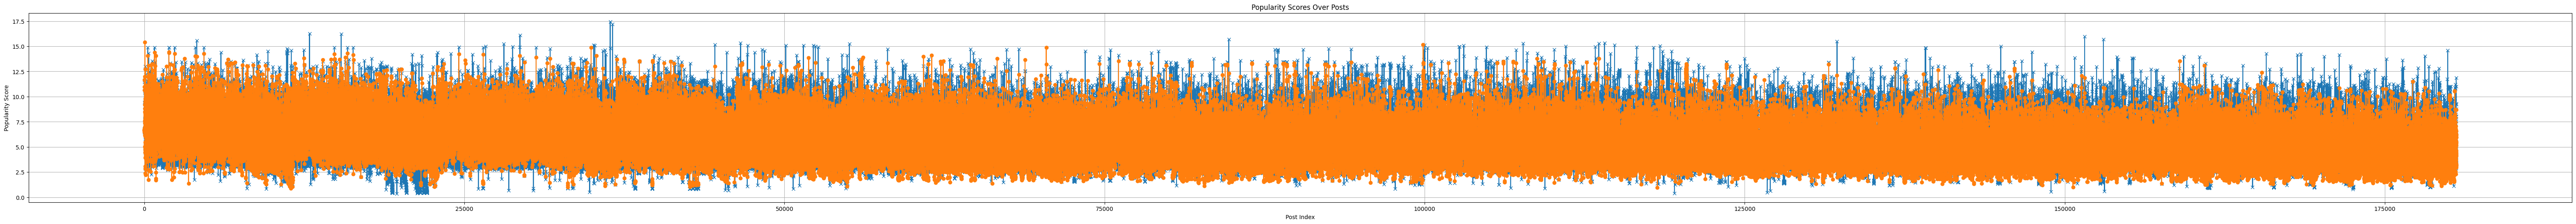

: 

In [37]:
import matplotlib.pyplot as plt


popularity_scores = [item['popularity_score'] for item in data['result']]
popularity_scores2 = list(data_array)

# 繪製折線圖
plt.figure(figsize=(80, 6))
plt.plot(popularity_scores2, marker='x', label='Series 2')
plt.plot(popularity_scores, marker='o',  label='Series 1')
plt.title('Popularity Scores Over Posts')
plt.xlabel('Post Index')
plt.ylabel('Popularity Score')
plt.grid(True)
plt.show()

In [ ]:
for item in data['result']:
    item['post_id'] = 'post' + item['post_id']
# Save to JSON file
output_path = '/ssd5/ming/CPDN/checkpoints/notresidue/updated_posts.json'
with open(output_path, 'w', encoding='utf-8') as file:
    json.dump(data, file, ensure_ascii=False, indent=4)

output_path

[10.654651, 11.658058, 10.979238, 6.721973, 6.704717, 6.649542, 6.608881, 6.588701, 6.669632, 6.730825, 6.628273, 6.722729, 6.461139, 6.68505, 6.656012, 6.704742, 6.681972, 6.484669, 6.809591, 6.687391, 6.623695, 6.84797, 6.693068, 6.753957, 6.740811, 6.717533, 6.771527, 6.809525, 6.684437, 6.59722, 6.564604, 6.978901, 6.590551, 6.608801, 6.544496, 6.737562, 6.682216, 6.664626, 6.653424, 6.743492, 6.689648, 6.654683, 8.822795, 6.190016, 11.984511, 15.413721, 7.589424, 7.377372, 9.175915, 5.052036, 7.579483, 8.475456, 6.451679, 8.280957, 9.791628, 4.417654, 4.908353, 7.793023, 8.330586, 2.823517, 4.771873, 8.519003, 8.443654, 8.022519, 7.149522, 9.458137, 3.941884, 9.454229, 4.85414, 9.543285, 4.671145, 6.054034, 5.496628, 8.133827, 7.856655, 2.396344, 4.439354, 3.088835, 4.488841, 7.742797, 10.985688, 12.712038, 9.377962, 7.357944, 6.88941, 7.561639, 5.482102, 7.948111, 4.602439, 2.210501, 5.143828, 5.101271, 4.969919, 4.7526, 10.41446, 5.170105, 5.321791, 5.355787, 5.145705, 5.154214,